# Derivation

Here we show how to perform derivatives and reduce discontinuities across interfaces.

#### Import general modules

In [1]:
# Import required modules
from mpi4py import MPI #equivalent to the use of MPI_init() in C
import matplotlib.pyplot as plt
import numpy as np

# Get mpi info
comm = MPI.COMM_WORLD

#### Import modules from pysemtools

In [2]:
from pysemtools.io.ppymech.neksuite import pynekread
from pysemtools.datatypes.msh import Mesh
from pysemtools.datatypes.coef import Coef
from pysemtools.datatypes.field import FieldRegistry

## Read the data and build objects

In this instance, we create connectivity for the mesh object, given that we wish to use direct stiffness summation to reduce discontinuities.

In [3]:
msh = Mesh(comm, create_connectivity=True)
fld = FieldRegistry(comm)
pynekread('../data/mixlay0.f00001', comm, data_dtype=np.double, msh=msh, fld=fld)
coef = Coef(msh, comm, get_area=False)

2024-09-03 16:27:48,686 - Mesh - INFO - Initializing empty Mesh object.
2024-09-03 16:27:48,688 - Field - INFO - Initializing empty Field object
2024-09-03 16:27:48,689 - pynekread - INFO - Reading file: ../data/mixlay0.f00001
2024-09-03 16:27:48,695 - Mesh - INFO - Initializing Mesh object from x,y,z ndarrays.
2024-09-03 16:27:48,696 - Mesh - INFO - Initializing common attributes.
2024-09-03 16:27:48,697 - Mesh - INFO - Getting vertices
2024-09-03 16:27:48,698 - Mesh - INFO - Getting vertices
2024-09-03 16:27:48,704 - Mesh - INFO - Facet centers not available for 2D
2024-09-03 16:27:48,705 - Mesh - INFO - Creating connectivity
2024-09-03 16:27:48,994 - Mesh - INFO - Mesh object initialized.
2024-09-03 16:27:48,995 - Mesh - INFO - Mesh data is of type: float64
2024-09-03 16:27:48,996 - Mesh - INFO - Elapsed time: 0.3014424720000001s
2024-09-03 16:27:48,997 - pynekread - INFO - Reading field data
2024-09-03 16:27:49,002 - pynekread - INFO - File read
2024-09-03 16:27:49,003 - pynekread 

### Plot the 2D velocity field

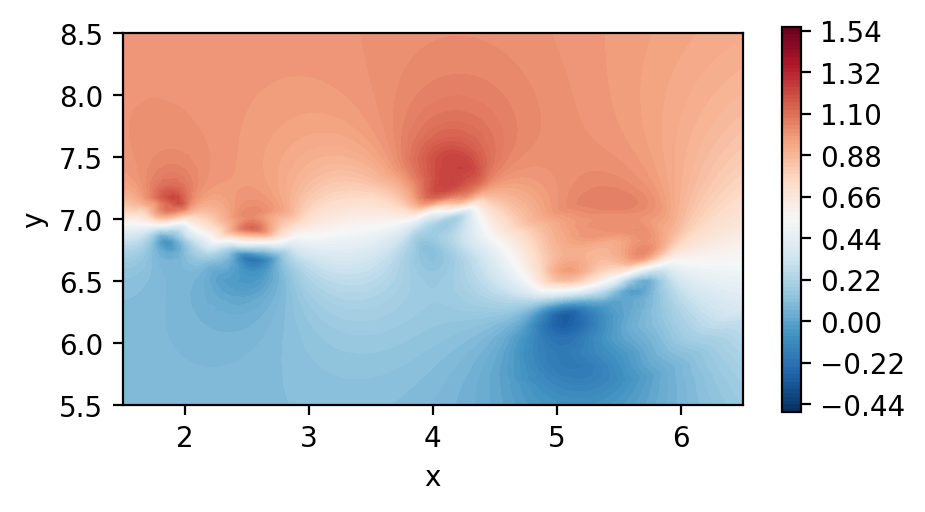

In [4]:
fig, ax = plt.subplots(figsize=(5, 2.5), dpi = 200)
c = ax.tricontourf(msh.x.flatten(), msh.y.flatten() ,fld.registry["u"].flatten(), levels=100, cmap="RdBu_r")
fig.colorbar(c)
ax.set_aspect('equal')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_xlim([1.5,6.5])
ax.set_ylim([5.5,8.5])
plt.show()

## Obtain x and y derivatives of u

Differentiation in physical space is done by using the chain rule. 

We always differentiate the the field in the reference element, i.e., we get: dudr, duds, dudt (in 3d).

To obtain the derivative in physical space, we must simply pass as inputs the components of the inverse of the jacobian matrix that will map the derivatives in the reference element to the direction we want.

For example in this case, to get the derivative in x we need to perform:

dudx = dudr * drdx + duds * dsdx

Therefore:

In [5]:
dudx = coef.dudxyz(fld.registry['u'], coef.drdx, coef.dsdx)
dudy = coef.dudxyz(fld.registry['u'], coef.drdy, coef.dsdy)

2024-09-03 16:27:50,499 - Coef - INFO - Calculating the derivative with respect to physical coordinates
2024-09-03 16:27:50,509 - Coef - INFO - done
2024-09-03 16:27:50,510 - Coef - INFO - Elapsed time: 0.00976063100000002s
2024-09-03 16:27:50,511 - Coef - INFO - Calculating the derivative with respect to physical coordinates
2024-09-03 16:27:50,521 - Coef - INFO - done
2024-09-03 16:27:50,521 - Coef - INFO - Elapsed time: 0.009097299999999864s


### Plot the derivatives

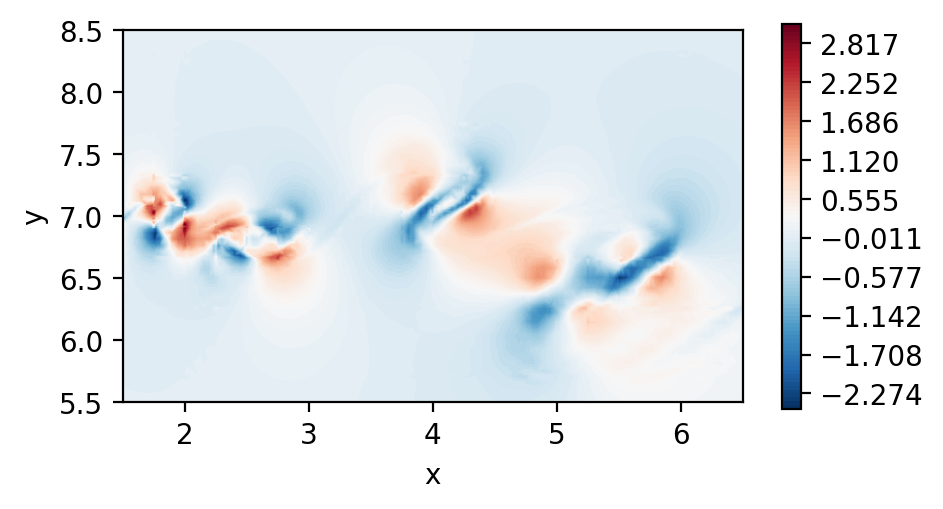

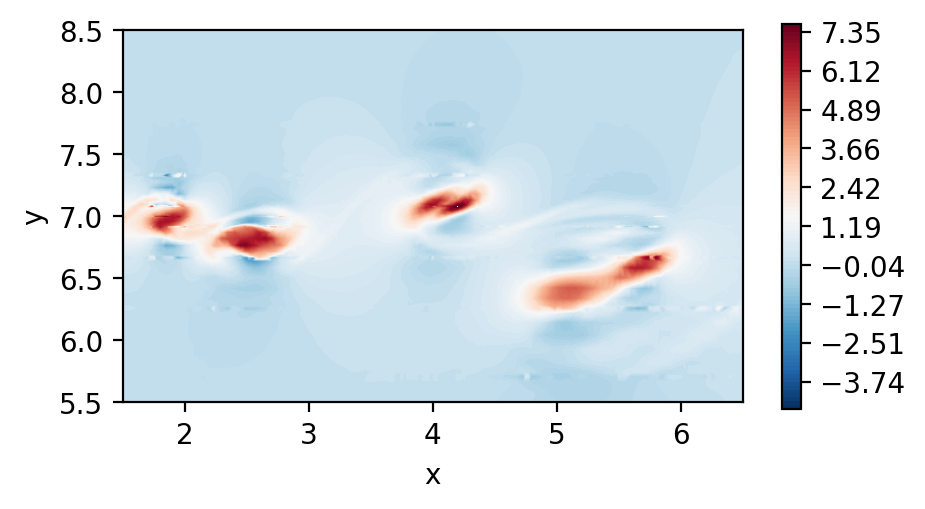

In [6]:
fig, ax = plt.subplots(figsize=(5, 2.5), dpi = 200)
c = ax.tricontourf(msh.x.flatten(), msh.y.flatten() ,dudx.flatten(), levels=np.linspace(-2.5,3.1,100), cmap="RdBu_r")
fig.colorbar(c)
ax.set_aspect('equal')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_xlim([1.5,6.5])
ax.set_ylim([5.5,8.5])
plt.show()

fig, ax = plt.subplots(figsize=(5, 2.5), dpi = 200)
c = ax.tricontourf(msh.x.flatten(), msh.y.flatten() ,dudy.flatten(), levels=np.linspace(-4.6,7.6,100), cmap="RdBu_r")
fig.colorbar(c)
ax.set_aspect('equal')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_xlim([1.5,6.5])
ax.set_ylim([5.5,8.5])
plt.show()

## Perform dssum on the derivatives (For serial execution)

In this instance, we call dssum the averaging procedure at the boundaries.

This could be modified.

In [7]:
dudx_2 = coef.dssum(dudx, msh)
dudy_2 = coef.dssum(dudy, msh)

2024-09-03 16:27:53,239 - Coef - INFO - Averaging field over shared points in the same rank
2024-09-03 16:27:55,852 - Coef - INFO - done
2024-09-03 16:27:55,853 - Coef - INFO - Elapsed time: 2.6137437180000003s
2024-09-03 16:27:55,854 - Coef - INFO - Averaging field over shared points in the same rank
2024-09-03 16:27:58,380 - Coef - INFO - done
2024-09-03 16:27:58,381 - Coef - INFO - Elapsed time: 2.5261967970000008s


### Plot the element boundary averaged derivatives

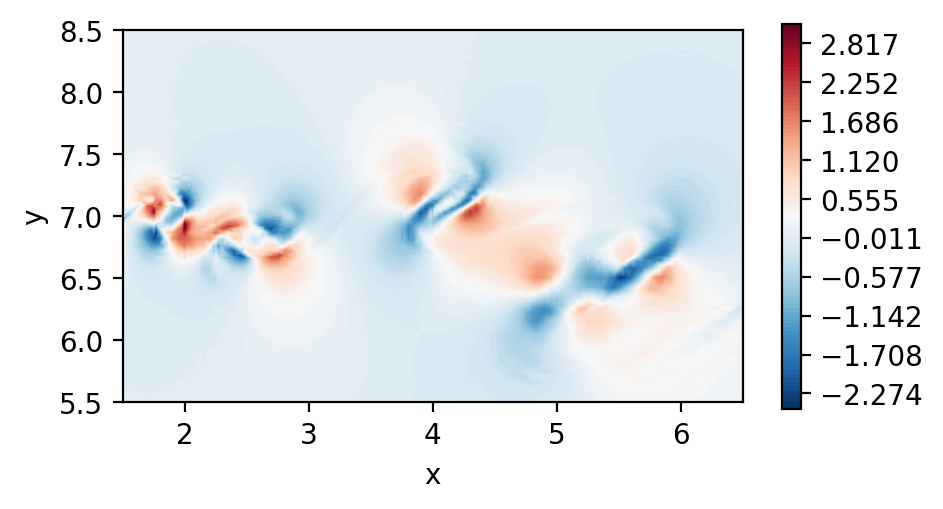

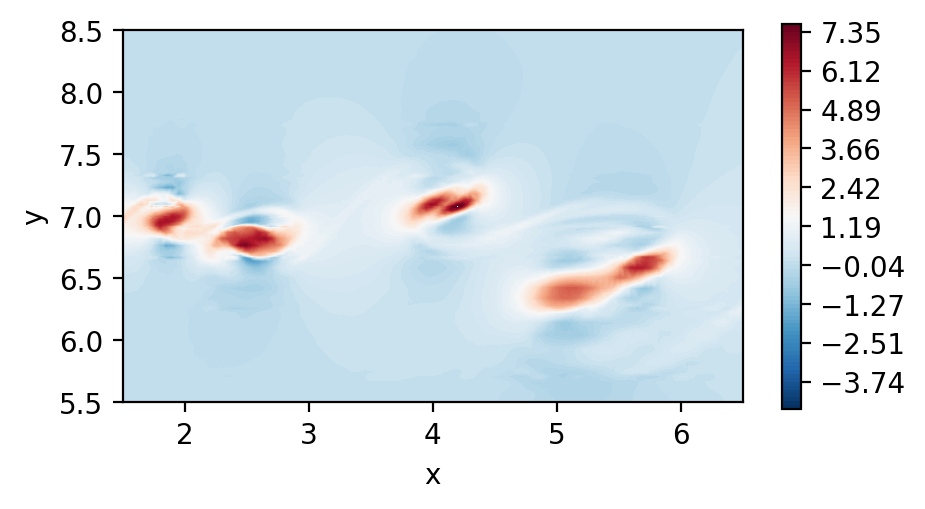

In [8]:
fig, ax = plt.subplots(figsize=(5, 2.5), dpi = 200)
c = ax.tricontourf(msh.x.flatten(), msh.y.flatten() ,dudx_2.flatten(), levels=np.linspace(-2.5,3.1,100), cmap="RdBu_r")
fig.colorbar(c)
ax.set_aspect('equal')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_xlim([1.5,6.5])
ax.set_ylim([5.5,8.5])
plt.show()

fig, ax = plt.subplots(figsize=(5, 2.5), dpi = 200)
c = ax.tricontourf(msh.x.flatten(), msh.y.flatten() ,dudy_2.flatten(), levels=np.linspace(-4.6,7.6,100), cmap="RdBu_r")
fig.colorbar(c)
ax.set_aspect('equal')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_xlim([1.5,6.5])
ax.set_ylim([5.5,8.5])
plt.show()

## Perform dssum (Parallel execution)

To perform parallel dssum, we must create a connectivity object that will know which vertices, edges and faces are shared between ranks.

The procedure to do that is the following:

In [9]:
from pysemtools.datatypes.msh_connectivity import MeshConnectivity

msh_conn = MeshConnectivity(comm, msh, rel_tol=1e-5)

2024-09-03 16:28:01,065 - MeshConnectivity - INFO - Initializing MeshConnectivity
2024-09-03 16:28:01,066 - MeshConnectivity - INFO - Computing local connectivity: Using vertices
2024-09-03 16:28:02,094 - MeshConnectivity - INFO - Computing local connectivity: Using edge centers
2024-09-03 16:28:03,111 - MeshConnectivity - INFO - Computing global connectivity: Using vertices
2024-09-03 16:28:03,113 - MeshConnectivity - INFO - Computing global connectivity: Using edge centers
2024-09-03 16:28:03,133 - MeshConnectivity - INFO - MeshConnectivity initialized
2024-09-03 16:28:03,134 - MeshConnectivity - INFO - Elapsed time: 2.068017022000001s


Note that the rel_tol is the relative tolerance used to determine if two points are the same in the mesh. The standard 1e-5 should suffice in most cases.

The actual dssum is performed next:

In [10]:
dudx_3 = msh_conn.dssum(field=dudx, msh=msh, average="multiplicity")
dudy_3 = msh_conn.dssum(field=dudy, msh=msh, average="multiplicity")

2024-09-03 16:28:03,145 - MeshConnectivity - INFO - Computing local dssum
2024-09-03 16:28:03,149 - MeshConnectivity - INFO - Adding vertices
2024-09-03 16:28:03,318 - MeshConnectivity - INFO - Adding edges
2024-09-03 16:28:05,435 - MeshConnectivity - INFO - Local dssum computed
2024-09-03 16:28:05,436 - MeshConnectivity - INFO - Elapsed time: 2.2869073150000006s
2024-09-03 16:28:05,437 - MeshConnectivity - INFO - Computing local dssum
2024-09-03 16:28:05,437 - MeshConnectivity - INFO - Adding vertices
2024-09-03 16:28:05,532 - MeshConnectivity - INFO - Adding edges
2024-09-03 16:28:07,707 - MeshConnectivity - INFO - Local dssum computed
2024-09-03 16:28:07,708 - MeshConnectivity - INFO - Elapsed time: 2.2705104439999992s


The average argument simply indicates that we want to perform an averaging procedure after the dssum, and that we want to do so by using the number of shared points as averaging weights.

### Plot the element boundary averaged derivatives

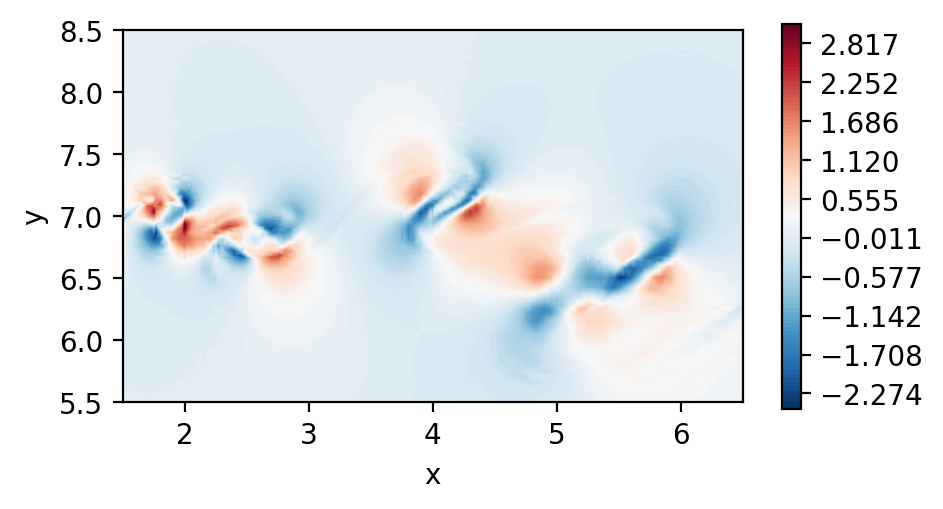

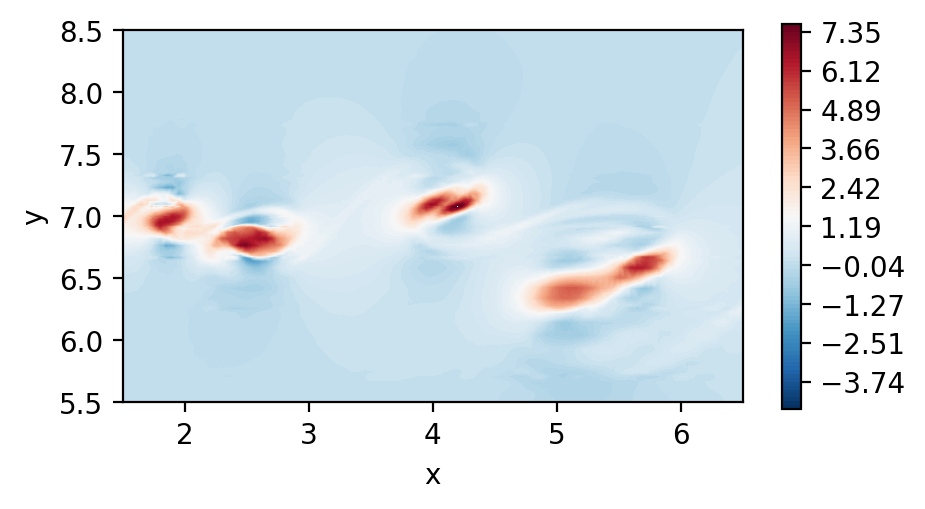

In [11]:
fig, ax = plt.subplots(figsize=(5, 2.5), dpi = 200)
c = ax.tricontourf(msh.x.flatten(), msh.y.flatten() ,dudx_3.flatten(), levels=np.linspace(-2.5,3.1,100), cmap="RdBu_r")
fig.colorbar(c)
ax.set_aspect('equal')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_xlim([1.5,6.5])
ax.set_ylim([5.5,8.5])
plt.show()

fig, ax = plt.subplots(figsize=(5, 2.5), dpi = 200)
c = ax.tricontourf(msh.x.flatten(), msh.y.flatten() ,dudy_3.flatten(), levels=np.linspace(-4.6,7.6,100), cmap="RdBu_r")
fig.colorbar(c)
ax.set_aspect('equal')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_xlim([1.5,6.5])
ax.set_ylim([5.5,8.5])
plt.show()